In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcdefaults()

In [30]:
DATA_FOLDER = "../Data/"

movies_imdb = pd.read_csv(DATA_FOLDER + 'movies_imdb.csv',
                          converters={'languages': parse_list, 'countries': parse_list, 'genresCmu': parse_list,
                                      'genresImdb': parse_list})

In [31]:
print(f"Percentage of data available for the budget: {round(100*(1-movies_imdb.budget.isna().sum()/movies_imdb.shape[0]), 3)}")

Percentage of data available for the budget: 3.426


In [32]:
movies_imdb.shape

(81630, 20)

Number of movies with runtime > 400: 66
Number of movies with negative runtime: 0
Number of movies with runtime between [0, 20]: 3102
Number of na values: 20396


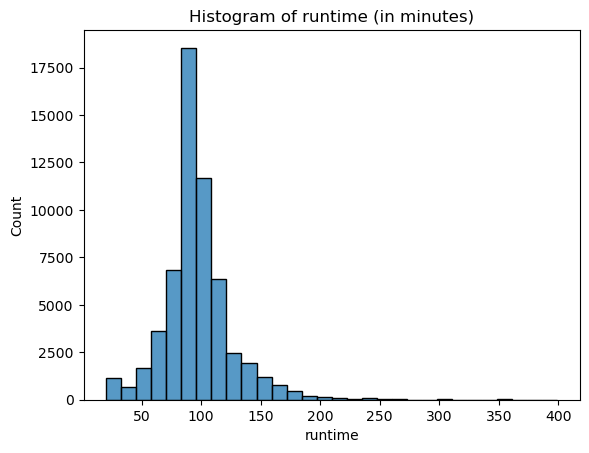

In [33]:
num_movies_gt_400 = len(movies_imdb[movies_imdb['runtime'] > 400])
num_movies_neg_runtime = len(movies_imdb[movies_imdb['runtime'] < 0])
num_movies_0_20_runtime = len(movies_imdb[(movies_imdb['runtime'] >= 0) & (movies_imdb['runtime'] <= 20)])

print(f"Number of movies with runtime > 400: {num_movies_gt_400}")
print(f"Number of movies with negative runtime: {num_movies_neg_runtime}")
print(f"Number of movies with runtime between [0, 20]: {num_movies_0_20_runtime}")

print(f"Number of na values: {movies_imdb['runtime'].isna().sum()}")

# Drop movies with runtime > 400, negative runtime and runtime between [0, 20] 
# (should we drop them or just set them to nan?)
movies_imdb = movies_imdb.drop(movies_imdb[movies_imdb['runtime'] > 400].index)
movies_imdb = movies_imdb.drop(movies_imdb[movies_imdb['runtime'] < 0].index)
movies_imdb = movies_imdb.drop(movies_imdb[(movies_imdb['runtime'] >= 0) & (movies_imdb['runtime'] <= 20)].index)

# Histogram of runtime
sns.histplot(data=movies_imdb, x="runtime", bins=30)
plt.title("Histogram of runtime (in minutes)")
plt.show()

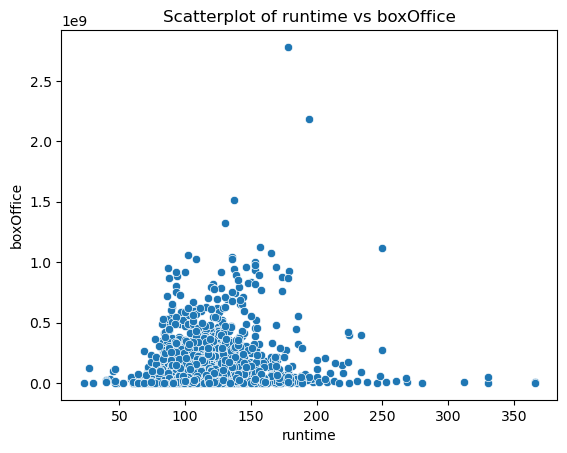

In [34]:
# Scatterplot of runtime vs boxOffice
sns.scatterplot(data=movies_imdb, x="runtime", y="boxOffice")
plt.title("Scatterplot of runtime vs boxOffice")
plt.show()

In [38]:
print(f"Number of movies with box office set to NaN: {movies_imdb['boxOffice'].isna().sum()}")
print(f"Proportion of movies with box office set to NaN: {movies_imdb['boxOffice'].isna().sum() / len(movies_imdb)}")

Number of movies with box office set to NaN: 70072
Proportion of movies with box office set to NaN: 0.8930692564553542


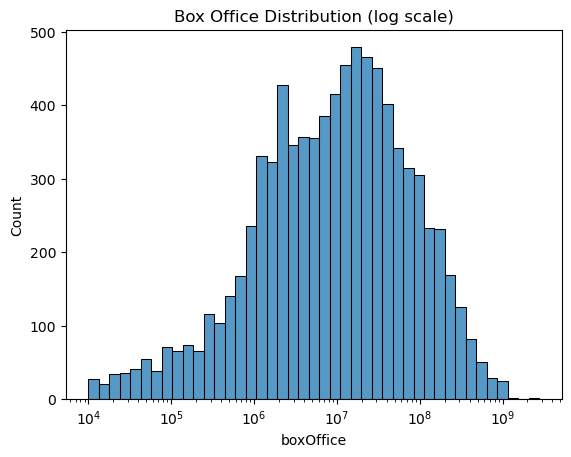

In [37]:
movies_imdb_no_nan = movies_imdb[movies_imdb[['boxOffice']].notna().all(axis=1)]
sns.histplot(data=movies_imdb_no_nan, x="boxOffice", log_scale=True)
plt.title("Box Office Distribution (log scale)")
plt.show()

In [101]:
def categorize_box_office(bo):
    if bo > 1e8:
        return 'Very High'
    elif bo > 1e7:
        return 'High'
    elif bo > 1e6:
        return 'Medium'
    else:
        return 'Low'

movies_imdb_no_nan['boxOfficeCategory'] = movies_imdb_no_nan['boxOffice'].apply(categorize_box_office)
movies_imdb_no_nan['boxOfficeCategory'] = pd.Categorical(movies_imdb_no_nan['boxOfficeCategory'], categories=['Very High', 'High', 'Medium', 'Low'], ordered=True)


In [102]:
movies_imdb_no_nan.groupby('boxOfficeCategory')['averageRating'].mean()

boxOfficeCategory
Very High    6.708529
High         6.354009
Medium       6.292848
Low          6.133571
Name: averageRating, dtype: float64

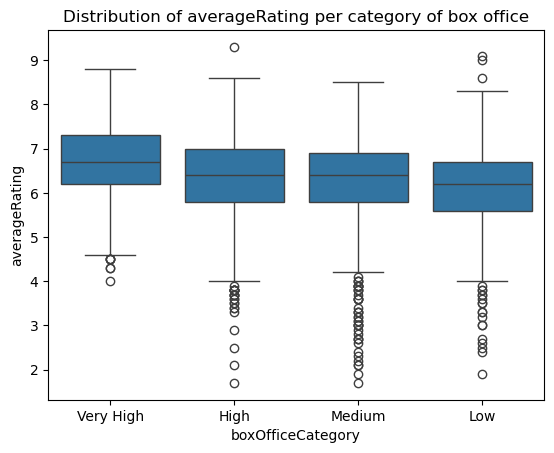

In [103]:
sns.boxplot(data=movies_imdb_no_nan, x='boxOfficeCategory', y='averageRating')
plt.title("Distribution of averageRating per category of box office")
plt.show()


In [153]:
characters_raw = pd.read_csv(DATA_FOLDER + "MovieSummaries/character.metadata.tsv", sep='\t')
oscars_raw = pd.read_csv(DATA_FOLDER + "Oscars/the_oscar_award.csv", sep=',')

characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "DOB",
    "gender",
    "height",
    "ethnicity",
    "name",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

oscars_raw = oscars_raw.drop(columns=["ceremony", "year_ceremony", "film"])
oscars_raw.rename(columns={"year_film": "releaseYear", "category": "oscarCategory", "winner": "oscarWinner"},
                  inplace=True)

characters = characters_raw.copy()
oscars = oscars_raw.copy()

characters["releaseYear"] = pd.to_datetime(
    characters["releaseDate"],
    errors="coerce",
    yearfirst=True,
).dt.year
characters["releaseMonth"] = pd.to_datetime(
    characters["releaseDate"],
    errors="coerce",
    yearfirst=True,
).dt.month
characters.drop(columns=["releaseDate"], inplace=True)

characters_oscars = pd.merge(characters, oscars, on=["name", 'releaseYear'], how="left")
print(characters_oscars.shape)
characters_oscars.head(10)

(450726, 16)


,wikiID,fbID,characterName,DOB,gender,height,ethnicity,name,ageAtMovieRelease,fbCharacterMap,fbCharacterID,fbActorID,releaseYear,releaseMonth,oscarCategory,oscarWinner
0,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,8.0,NaN,NaN
1,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,8.0,NaN,NaN
2,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,8.0,NaN,NaN
3,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,8.0,NaN,NaN
4,975900,/m/03vyhn,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001.0,8.0,NaN,NaN
5,975900,/m/03vyhn,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001.0,8.0,NaN,NaN
6,975900,/m/03vyhn,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001.0,8.0,NaN,NaN
7,975900,/m/03vyhn,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001.0,8.0,NaN,NaN
8,975900,/m/03vyhn,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001.0,8.0,NaN,NaN
9,975900,/m/03vyhn,Dos,NaN,M,NaN,NaN,Lobo Sebastian,NaN,/m/0bgchsc,/m/0bgchsg,/m/0bgchsp,2001.0,8.0,NaN,NaN


In [154]:
movies_actors = pd.merge(movies_imdb, characters_oscars, on=['fbID', 'wikiID', 'releaseYear', 'releaseMonth'], how='inner', suffixes=('Movie', 'Actor'))
print(movies_actors.shape)

(279112, 33)


In [155]:
movies_actors['boxOfficeCategory'] = movies_actors['boxOffice'].apply(categorize_box_office)
movies_actors['boxOfficeCategory'] = pd.Categorical(movies_actors['boxOfficeCategory'], categories=['Very High', 'High', 'Medium', 'Low'], ordered=True)

J'ai drop les acteurs ayant joue dans moins de 10 films!

In [156]:
# Drop actors that have acted in less than 10 movies
actor_counts = movies_actors.groupby('nameActor')['nameMovie'].count().reset_index()
actor_counts = actor_counts[actor_counts['nameMovie'] >= 10]
print(actor_counts.shape)


# Filter out actors whose names are not in the actor_counts dataframe
movies_actors = movies_actors[movies_actors['nameActor'].isin(actor_counts['nameActor'])]
print(movies_actors.shape)

(5737, 2)
(116419, 33)


In [157]:
num_unique_actors = movies_actors['nameActor'].nunique()
print(f"Number of unique actors in these movies: {num_unique_actors}")

Number of unique actors in these movies: 5737


On a 5737 acteurs!

In [158]:
movies_actors.groupby(['boxOfficeCategory', 'gender'])['ageAtMovieRelease'].mean()

boxOfficeCategory  gender
Very High          F         37.031636
                   M         44.520644
High               F         36.718901
                   M         43.136431
Medium             F         35.578465
                   M         42.140969
Low                F         33.847059
                   M         42.813633
Name: ageAtMovieRelease, dtype: float64

In [159]:
career_lengths = movies_actors.groupby('nameActor').agg({'releaseYear': ['min', 'max'], 'ageAtMovieRelease': 'min'})
career_lengths.columns = ['first_movie_year', 'last_movie_year', 'age_at_first_movie']
career_lengths['career_length'] = career_lengths['last_movie_year'] - career_lengths['first_movie_year']
career_lengths = career_lengths[['first_movie_year', 'last_movie_year', 'career_length', 'age_at_first_movie']]
career_lengths['age_at_last_movie'] = career_lengths['age_at_first_movie'] + career_lengths['career_length']
career_lengths.head()

,first_movie_year,last_movie_year,career_length,age_at_first_movie,age_at_last_movie
nameActor,,,,,
50 Cent,2003.0,2011.0,8.0,27.0,35.0
A.K Hangal,1971.0,2004.0,33.0,54.0,87.0
Aahuthi Prasad,2002.0,2011.0,9.0,NaN,NaN
Aamir Khan,1985.0,2012.0,27.0,20.0,47.0
Aaron Eckhart,1997.0,2013.0,16.0,28.0,44.0


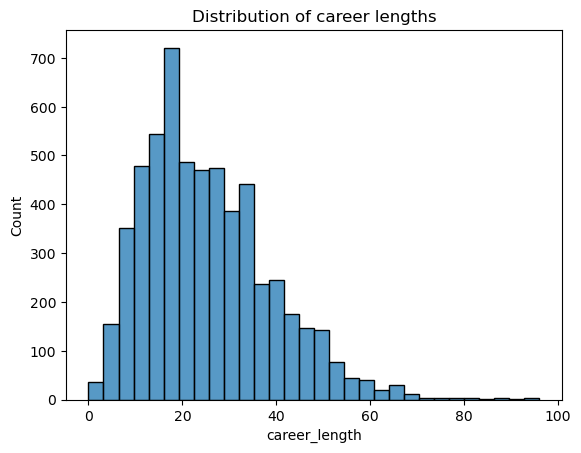

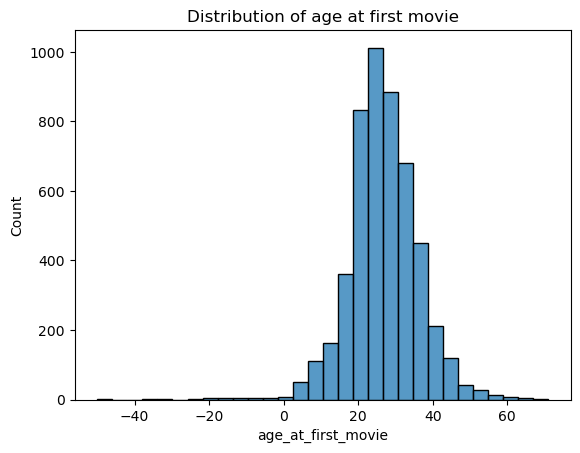

In [160]:
sns.histplot(data=career_lengths, x="career_length", bins=30)
plt.title("Distribution of career lengths")
plt.show()

sns.histplot(data=career_lengths, x="age_at_first_movie", bins=30)
plt.title("Distribution of age at first movie")
plt.show()



In [161]:
movies_actors.head()

,wikiID,fbID,nameMovie,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes,budget,popularity,boxOfficeCategory,characterName,DOB,gender,height,ethnicity,nameActor,ageAtMovieRelease,fbCharacterMap,fbCharacterID,fbActorID,oscarCategory,oscarWinner
5,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,John Ramsey,1945-02-12,M,1.85,NaN,Cliff DeYoung,55.0,/m/0lr37f7,/m/0lr3z8x,/m/07jbhb,NaN,NaN
10,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,NaN,NaN
15,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",5.0,1913.0,tt0002894,short,The Gangsters,0.0,\N,"[Comedy, Short]",6.8,16.0,NaN,NaN,Low,Cop,1887-03-24,M,1.78,/m/07bch9,Roscoe Arbuckle,NaN,/m/040l8c4,/m/0h5km4p,/m/0k57l,NaN,NaN
17,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",8.0,1938.0,tt0029852,movie,Alexander's Ragtime Band,0.0,\N,"[Drama, Music, Musical]",6.8,2264.0,2000000.0,0.632261,Medium,Roger Grant AKA Alexander,1914-05-05,M,1.82,/m/06v41q,Tyrone Power,24.0,/m/02vbvj2,/m/0h36wrs,/m/02s58t,NaN,NaN
18,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",8.0,1938.0,tt0029852,movie,Alexander's Ragtime Band,0.0,\N,"[Drama, Music, Musical]",6.8,2264.0,2000000.0,0.632261,Medium,NaN,1915-05-05,F,1.65,/m/033tf_,Alice Faye,23.0,/m/02vbq8t,NaN,/m/032xfz,NaN,NaN


Bon, go faire un actors dataframe avec toutes les infos dedans sur eux, je pense que ca pourrait etre utile pour tout le monde

In [191]:
actors_info = movies_actors.groupby('nameActor').agg({
    'DOB': 'first',
    'gender': 'first',
    'ethnicity': 'first',
    'oscarCategory': lambda x: x.notna().sum(),
    'oscarWinner': lambda x: x.notna().sum(),
    'fbCharacterMap': 'first',
    'fbCharacterID': 'first',
    'fbActorID': 'first',
    'height': 'first'
}).reset_index()

actors_info.columns = ['Name', 'DOB', 'gender', 'Ethnicity', 'Oscar_Nominated', 'Oscar_Winner', 'fbCharacterMap', 'fbCharacterID', 'fbActorID', 'height']

In [192]:
career_lengths = movies_actors.groupby('nameActor').agg({'releaseYear': ['min', 'max'], 'ageAtMovieRelease': 'min'})
career_lengths.columns = ['first_movie_year', 'last_movie_year', 'age_at_first_movie']
career_lengths['career_length'] = career_lengths['last_movie_year'] - career_lengths['first_movie_year']
career_lengths = career_lengths[['first_movie_year', 'last_movie_year', 'career_length', 'age_at_first_movie']]

actors_info = pd.merge(actors_info, career_lengths, left_on='Name', right_index=True)
actors_info.head()

,Name,DOB,gender,Ethnicity,Oscar_Nominated,Oscar_Winner,fbCharacterMap,fbCharacterID,fbActorID,height,first_movie_year,last_movie_year,career_length,age_at_first_movie
0,50 Cent,1975-07-06,M,/m/0x67,0,0,/m/09zmmhp,/m/0h5vcx4,/m/01vvyc_,1.829,2003.0,2011.0,8.0,27.0
1,A.K Hangal,1917-02-01,M,/m/023mqw,0,0,/m/05nq6_7,/m/0h70rpf,/m/04hqbbz,NaN,1971.0,2004.0,33.0,54.0
2,Aahuthi Prasad,None,M,None,0,0,/m/0gclskn,/m/0h89zcq,/m/0gbymjy,NaN,2002.0,2011.0,9.0,NaN
3,Aamir Khan,1965-03-14,M,/m/0dllcfn,0,0,/m/04hv56d,/m/0gxp8g7,/m/015npr,1.680,1985.0,2012.0,27.0,20.0
4,Aaron Eckhart,1968-03-12,M,None,0,0,/m/02tb612,/m/0cby_67,/m/03t4cz,1.830,1997.0,2013.0,16.0,28.0


In [193]:
# Create a pivot table with counts of movies for each actor and box office category
pivot_table = pd.pivot_table(movies_actors, index='nameActor', columns='boxOfficeCategory', values='nameMovie', aggfunc='count', fill_value=0)

# Merge the pivot table with actors_info dataframe
actors_info = pd.merge(actors_info, pivot_table, left_on='Name', right_index=True)


In [194]:
actors_info.head()

,Name,DOB,gender,Ethnicity,Oscar_Nominated,Oscar_Winner,fbCharacterMap,fbCharacterID,fbActorID,height,first_movie_year,last_movie_year,career_length,age_at_first_movie,Very High,High,Medium,Low
0,50 Cent,1975-07-06,M,/m/0x67,0,0,/m/09zmmhp,/m/0h5vcx4,/m/01vvyc_,1.829,2003.0,2011.0,8.0,27.0,0,3,1,10
1,A.K Hangal,1917-02-01,M,/m/023mqw,0,0,/m/05nq6_7,/m/0h70rpf,/m/04hqbbz,NaN,1971.0,2004.0,33.0,54.0,0,0,0,21
2,Aahuthi Prasad,None,M,None,0,0,/m/0gclskn,/m/0h89zcq,/m/0gbymjy,NaN,2002.0,2011.0,9.0,NaN,0,0,0,18
3,Aamir Khan,1965-03-14,M,/m/0dllcfn,0,0,/m/04hv56d,/m/0gxp8g7,/m/015npr,1.680,1985.0,2012.0,27.0,20.0,0,0,0,29
4,Aaron Eckhart,1968-03-12,M,None,0,0,/m/02tb612,/m/0cby_67,/m/03t4cz,1.830,1997.0,2013.0,16.0,28.0,3,13,3,7


Nombre de films de chaque categorie dependant de si nomine a un oscar

In [195]:
print(actors_info.query('Oscar_Nominated > 0')['Very High'].mean())
print(actors_info.query('Oscar_Nominated > 0')['High'].mean())
print(actors_info.query('Oscar_Nominated > 0')['Medium'].mean())
print(actors_info.query('Oscar_Nominated > 0')['Low'].mean())


3.381165919282511
6.460388639760837
3.8370702541106128
15.57847533632287


In [196]:

print(actors_info.query('Oscar_Nominated == 0')['Very High'].mean())
print(actors_info.query('Oscar_Nominated == 0')['High'].mean())
print(actors_info.query('Oscar_Nominated == 0')['Medium'].mean())
print(actors_info.query('Oscar_Nominated == 0')['Low'].mean())

1.5011838989739543
2.952446724546172
1.4591554853985793
13.1965272296764


In [199]:
print(actors_info.query('Oscar_Nominated > 0').career_length.mean())
print(actors_info.query('Oscar_Nominated == 0').career_length.mean())

print(actors_info.query('Oscar_Nominated > 0').age_at_first_movie.mean())
print(actors_info.query('Oscar_Nominated == 0').age_at_first_movie.mean())

print("Mean career length for Oscar-nominated actors:")
print(actors_info.query('Oscar_Nominated > 0').groupby('gender')['career_length'].mean())

print("Mean career length for non-Oscar-nominated actors:")
print(actors_info.query('Oscar_Nominated == 0').groupby('gender')['career_length'].mean())

print("Mean age at first movie for Oscar-nominated actors:")
print(actors_info.query('Oscar_Nominated > 0').groupby('gender')['age_at_first_movie'].mean())

print("Mean age at first movie for non-Oscar-nominated actors:")
print(actors_info.query('Oscar_Nominated == 0').groupby('gender')['age_at_first_movie'].mean())


34.52017937219731
23.976519337016576
25.946308724832214
26.673696145124715
Mean career length for Oscar-nominated actors:
gender
F    32.741611
M    35.948787
Name: career_length, dtype: float64
Mean career length for non-Oscar-nominated actors:
gender
F    21.835811
M    24.917069
Name: career_length, dtype: float64
Mean age at first movie for Oscar-nominated actors:
gender
F    23.875912
M    27.708075
Name: age_at_first_movie, dtype: float64
Mean age at first movie for non-Oscar-nominated actors:
gender
F    22.758669
M    28.519520
Name: age_at_first_movie, dtype: float64


In [198]:
actors_info.query('Oscar_Nominated > 0').groupby('gender')['gender'].count() / actors_info.query('Oscar_Nominated > 0').shape[0]

gender
F    0.445441
M    0.554559
Name: gender, dtype: float64

What if we do a score?


In [215]:
# Calculate the score for each actor
actors_info['score'] = 0.7 * (actors_info[['Very High']].sum(axis=1)) + 0.4 * (actors_info[['High']].sum(axis=1))+ 0.1 * (actors_info[['Medium']].sum(axis=1)) + 0.01 * (actors_info[['Low']].sum(axis=1))+ (0.6* actors_info['Oscar_Winner']) + (0.3* actors_info['Oscar_Nominated'])

actors_info = actors_info.sort_values(by='score', ascending=False)
actors_info.head()


,Name,DOB,gender,Ethnicity,Oscar_Nominated,Oscar_Winner,fbCharacterMap,fbCharacterID,fbActorID,height,first_movie_year,last_movie_year,career_length,age_at_first_movie,Very High,High,Medium,Low,score
4563,Robert De Niro,1943-08-17,M,/m/0xnvg,16,16,/m/0gxsd1c,/m/0h0tdml,/m/06cgy,1.770,1968.0,2012.0,44.0,25.0,14,29,14,19,37.39
3618,Meryl Streep,1949-06-22,F,None,23,23,/m/0gxgwc3,/m/0gy2y5t,/m/0h0wc,1.680,1977.0,2012.0,35.0,28.0,11,18,2,7,35.87
4782,Samuel L. Jackson,1948-12-21,M,/m/0x67,4,4,/m/0j_82l,/m/0gy9cyc,/m/0f5xn,1.890,1981.0,2013.0,32.0,32.0,25,29,9,24,33.84
4620,Robin Williams,1951-07-21,M,None,9,9,/m/0jx3b3,/m/0gwtmbw,/m/0dzf_,1.702,1980.0,2012.0,32.0,29.0,20,22,4,16,31.46
3932,Nicolas Cage,1964-01-07,M,/m/01qhm_,6,6,/m/02h7l58,/m/02nwj_p,/m/01vvb4m,1.830,1980.0,2013.0,33.0,16.0,17,31,6,11,30.41


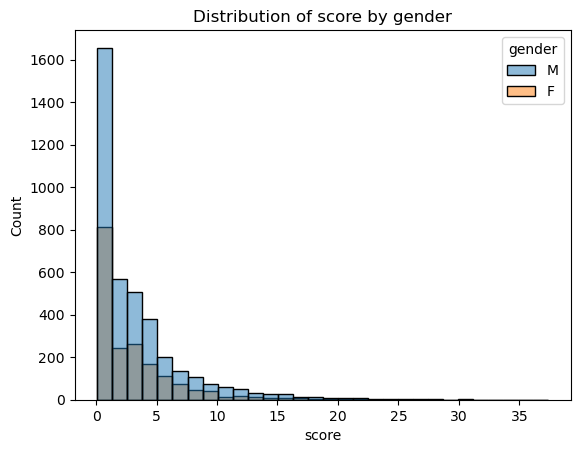

In [219]:
sns.histplot(data=actors_info, x="score", bins=30, hue="gender")
plt.title("Distribution of score by gender")
plt.show()


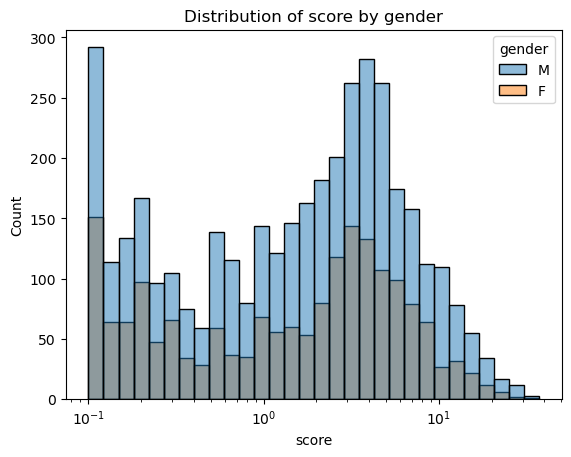

In [220]:
sns.histplot(data=actors_info, x="score", bins=30, hue="gender", log_scale=True)
plt.title("Distribution of score by gender")
plt.show()